<h2>Introduction

An online automotive parts business is growing rapidly and is looking to expand. The business is currently headquartered in Las Vegas, Nevada, and has a large warehouse onsite. Since this company ships products all over the United States, the business executives believe that it would be advantageous to locate the new warehouse in a strategic location. Several factors come into play. They would like to be located near their largest customer base to cut down on shipping costs. They would like to purchase an existing warehouse in an area that is affordable, to keep operational costs down. And finally, they would like an area that is near an international airport.   

<h2> Data Sources

The data needed to help solve this problem will have to come from a few different sources. To target the company’s biggest customer pools, we will have to use an invoice roster to view shipping addresses. We can add up which zip codes have the most traffic, both with the number of sales and total items shipped. It may also be helpful to look at the purchase price of items and factor that in. 

We can then merge this data with a dataset acquired from Zillow, that shows median home cost by zipcode. This is an accessible, and applicable data file that should help to identify areas that may have business real estate prices that are too high. 

Once our data is narrowed down to a few strategic locations, we will use Foursquare location data to see if there are international airports nearby.

Based on these analyses, we should be able to pinpoint some ideal locations for this company to expand to.


<h2>Analysis

In [1]:
#import python libraries 
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
%matplotlib inline
from sklearn.cluster import KMeans

In [2]:
sales = pd.read_excel(r'C:\Users\keving\Documents\Excel Files\CUSTOMERS\Invoices.xlsx')

In [4]:
sales.head(10)

,Date,InvoiceNumber,ShippingZip,QTY,Price
0,2019-10-24,1231066,98204,1,5250.00
1,2019-10-24,1231066,98204,1,5250.00
2,2019-10-24,1231081,91766,1,690.00
3,2019-10-24,1231073,75402,1,600.00
4,2019-10-24,1231070,67152,1,85.00
5,2019-10-24,1231070,67152,1,85.00
6,2019-10-24,1231070,67152,1,120.00
7,2019-10-24,1231070,67152,1,100.00
8,2019-10-24,1231079,33966,2,400.00
9,2019-10-24,1231078,33186,1,237.81


In [4]:
print('{:,} rows; {:,} columns'.format(sales.shape[0], sales.shape[1]))

111,518 rows; 5 columns


In [5]:
#create a timestamp from one day after the most recent sale
NOW = sales['Date'].max() + timedelta(days=1)

#define our data period as being over the last 9 years (9x365 = 3285 days)
period = 365

In [6]:
#create a new column, calculating the days since the last order
sales['DaysSinceOrder'] = sales['Date'].apply(lambda x: (NOW - x).days)
#Preview the top 5 entires to see the updated column
sales.head()

,Date,InvoiceNumber,ShippingZip,QTY,Price,DaysSinceOrder
0,2019-10-24,1231066,98204,1,5250.0,1
1,2019-10-24,1231066,98204,1,5250.0,1
2,2019-10-24,1231081,91766,1,690.0,1
3,2019-10-24,1231073,75402,1,600.0,1
4,2019-10-24,1231070,67152,1,85.0,1


In [7]:
#Lets convert our days since last order to a new column called recency
#The total number of orders from a customer is calculated to be the frequency
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'Date': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = sales.groupby('ShippingZip').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'Date': 'Frequency'}, inplace=True)
#Let's look at the top 5 entires of this new dataframe
rfm.head()

,ShippingZip,Recency,Frequency
0,10577,137,1
1,11434,8,9
2,14120,105,1
3,20008,80,1
4,20166,39,1


In [10]:
#Let's add the sum of each invoice for a given customer to create their total sales over the time period
#To complete our RFM data frame, the new column in names Monetary
rfm['Monetary'] = rfm['ShippingZip'].apply(lambda x: sales[(sales['ShippingZip'] == x) & \
                                                           (sales['Date'] >= NOW - timedelta(days=period))]\
                                                           ['Price'].sum())
rfm.head(10)

,ShippingZip,Recency,Frequency,Monetary
0,10577,137,1,0.00
1,11434,8,9,29282.81
2,14120,105,1,661.56
3,20008,80,1,0.00
4,20166,39,1,5.00
5,27410,3,105,50835.12
6,28110,312,1,900.00
7,30043,261,4,551.70
8,30354,3,235,328887.84
9,32583,360,1,500.00


In [12]:
print('{:,} rows; {:,} columns'.format(rfm.shape[0], rfm.shape[1]))

1,060 rows; 5 columns


In [9]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]
# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

In [11]:
#Create a cluster score for recency. The number of clusters to be analyzed is 4. This will be shown to be revelant later
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm[['Recency']])
rfm['R_Cluster'] = kmeans.predict(rfm[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

rfm = order_cluster('R_Cluster', 'Recency',rfm,False)

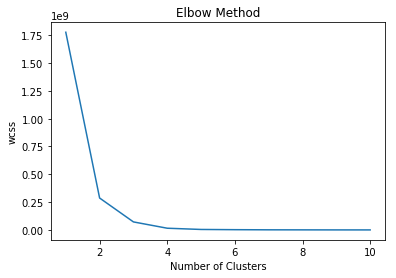

In [13]:
#Create a cluster score for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm[['Frequency']])
rfm['F_Cluster'] = kmeans.predict(rfm[['Frequency']])

#order the frequency cluster
rfm = order_cluster('F_Cluster', 'Frequency',rfm,True)

#see details of each cluster
rfm.groupby('F_Cluster')['Frequency'].describe()

#plot our elbow graph to verift the cluster amount to expiertment with. At 4 clusters the graph shallows
#so this is a good value to start an analysis with
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(rfm[['Frequency']])
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

In [14]:
#Create a cluster score for monetary
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm[['Monetary']])
rfm['M_Cluster'] = kmeans.predict(rfm[['Monetary']])


#order the cluster numbers
rfm = order_cluster('M_Cluster', 'Monetary',rfm,True)

In [15]:
#Lets visualize the new data structure by looking at the first 5 entries
rfm.head()

,ShippingZip,Recency,Frequency,Monetary,R_Cluster,F_Cluster,M_Cluster
0,10577,137,1,0.00,2,0,0
1,14120,105,1,661.56,2,0,0
2,20008,80,1,0.00,2,0,0
3,33172,95,4,4915.00,2,0,0
4,33311,161,2,120.85,2,0,0


In [17]:
rfm['K_Score'] = rfm['R_Cluster']+rfm['F_Cluster']+rfm['M_Cluster']

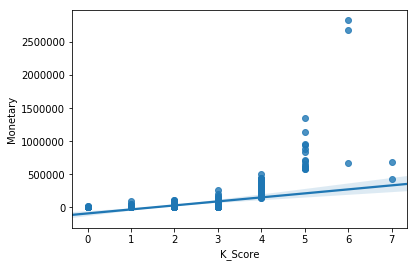

In [18]:
#Let's verify that the K_Score is correlated to the amount of money spent. In theory high K Scores should be the best customers
sns.regplot(x=rfm["K_Score"], y=rfm["Monetary"])

In [19]:
#Let's assign human readable values to the K scores. These values are chosen by guess and check and can be altered
rfm['K_Rating'] = 'Low-Value'
rfm.loc[rfm['K_Score']>2,'K_Rating'] = 'Mid-Value' 
rfm.loc[rfm['K_Score']>4,'K_Rating'] = 'High-Value' 
#Look at the top 5 entires of the new dataset
rfm.head()

,ShippingZip,Recency,Frequency,Monetary,R_Cluster,F_Cluster,M_Cluster,K_Score,K_Rating
0,10577,137,1,0.00,2,0,0,2,Low-Value
1,14120,105,1,661.56,2,0,0,2,Low-Value
2,20008,80,1,0.00,2,0,0,2,Low-Value
3,33172,95,4,4915.00,2,0,0,2,Low-Value
4,33311,161,2,120.85,2,0,0,2,Low-Value


In [20]:
rfm.groupby('K_Score')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
K_Score,,,
0,318.570370,1.911111,1.813839e+03
1,225.662162,3.114865,4.950085e+03
2,119.674107,6.254464,6.961027e+03
3,25.227273,28.345041,2.362426e+04
4,6.666667,270.145833,2.795497e+05
5,10.687500,453.687500,7.756195e+05
6,4.333333,2700.000000,2.063107e+06
7,2.000000,27358.000000,5.574412e+05


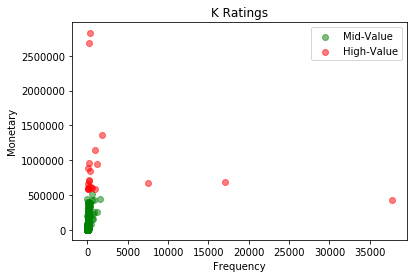

In [21]:
#Let's plot our customer clusters
x=rfm.query("K_Rating== 'Low-Value'")['Frequency']
y=rfm.query("K_Rating == 'Low-Value'")['Monetary']
#plt.scatter(rfm.query("K_Rating== 'Low-Value'")['Frequency'],rfm.query("K_Rating == 'Low-Value'")['Monetary'] , c='blue', alpha=0.5, label="Low-Value")
plt.scatter(rfm.query("K_Rating== 'Mid-Value'")['Frequency'],rfm.query("K_Rating == 'Mid-Value'")['Monetary'] , c='green', alpha=0.5, label="Mid-Value")
plt.scatter(rfm.query("K_Rating== 'High-Value'")['Frequency'],rfm.query("K_Rating == 'High-Value'")['Monetary'] , c='red', alpha=0.5, label="High-Value")

plt.title('K Ratings')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(loc=1)
plt.show()

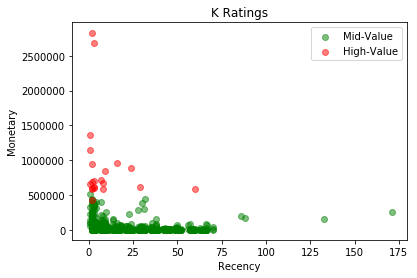

In [22]:
#plt.scatter(rfm.query("K_Rating== 'Low-Value'")['Recency'],rfm.query("K_Rating == 'Low-Value'")['Monetary'] , c='blue', alpha=0.5, label="Low-Value")
plt.scatter(rfm.query("K_Rating== 'Mid-Value'")['Recency'],rfm.query("K_Rating == 'Mid-Value'")['Monetary'] , c='green', alpha=0.5, label="Mid-Value")
plt.scatter(rfm.query("K_Rating== 'High-Value'")['Recency'],rfm.query("K_Rating == 'High-Value'")['Monetary'] , c='red', alpha=0.5, label="High-Value")

plt.title('K Ratings')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(loc=1)
plt.show()

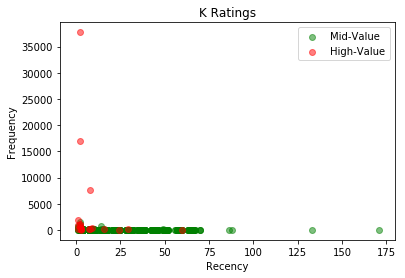

In [23]:
#plt.scatter(rfm.query("K_Rating== 'Low-Value'")['Recency'],rfm.query("K_Rating == 'Low-Value'")['Frequency'] , c='blue', alpha=0.5, label="Low-Value")
plt.scatter(rfm.query("K_Rating== 'Mid-Value'")['Recency'],rfm.query("K_Rating == 'Mid-Value'")['Frequency'] , c='green', alpha=0.5, label="Mid-Value")
plt.scatter(rfm.query("K_Rating== 'High-Value'")['Recency'],rfm.query("K_Rating == 'High-Value'")['Frequency'] , c='red', alpha=0.5, label="High-Value")

plt.title('K Ratings')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(loc=1)
plt.show()

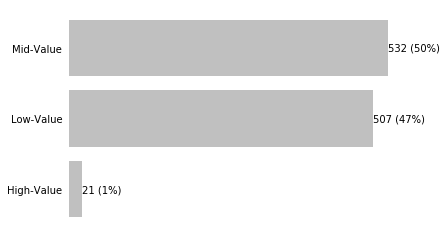

In [24]:
#Visualize the distrubtion of the customer clusters.
segments_counts = rfm['K_Rating'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [25]:
#Let's look at 50 of our highest rated customers by K Score Rating. 
targets = rfm[rfm['K_Rating']=="High-Value"]
targets = targets.reset_index(drop=True)

In [26]:
targets


,ShippingZip,Recency,Frequency,Monetary,R_Cluster,F_Cluster,M_Cluster,K_Score,K_Rating
0,33126,2,37718,427524.94,3,3,1,7,High-Value
1,45177,2,565,597780.50,3,0,2,5,High-Value
2,74116,3,389,616513.63,3,0,2,5,High-Value
3,89118,60,36,584000.00,3,0,2,5,High-Value
4,05404,29,240,620400.00,3,0,2,5,High-Value
5,07751,24,30,886650.00,3,0,2,5,High-Value
6,33069,8,124,587793.53,3,0,2,5,High-Value
7,33122,1,959,1141977.18,3,0,2,5,High-Value
8,33166,1,1810,1359175.83,3,0,2,5,High-Value
9,33172,2,1127,943721.66,3,0,2,5,High-Value


In [90]:
targets['Latitude']=[25.78,39.45,36.19,36.17,44.49,40.37,26.23,25.80,25.82,25.79,25.84,39.01,41.57,41.90,33.09,33.29,33.27,25.99,33.30,35.03,33.44]
targets['Longitude'] = [-80.29, -83.80,-95.84,-115.14,-73.18,-74.25,-80.16,-80.32,-80.31,-80.36,-80.43,-84.6,-93.81,-87.68,-96.09,-111.94,-111.82,-80.28,-111.84,-89.93,-112.02]

In [84]:
targets

,ShippingZip,Recency,Frequency,Monetary,R_Cluster,F_Cluster,M_Cluster,K_Score,K_Rating,Latitude,Longitude
0,33126,2,37718,427524.94,3,3,1,7,High-Value,25.78,-80.29
1,45177,2,565,597780.50,3,0,2,5,High-Value,39.45,-83.80
2,74116,3,389,616513.63,3,0,2,5,High-Value,36.19,-95.84
3,89118,60,36,584000.00,3,0,2,5,High-Value,36.17,-115.14
4,05404,29,240,620400.00,3,0,2,5,High-Value,44.49,-73.18
5,07751,24,30,886650.00,3,0,2,5,High-Value,40.37,-74.25
6,33069,8,124,587793.53,3,0,2,5,High-Value,26.23,-80.16
7,33122,1,959,1141977.18,3,0,2,5,High-Value,25.80,-80.32
8,33166,1,1810,1359175.83,3,0,2,5,High-Value,25.82,-80.31
9,33172,2,1127,943721.66,3,0,2,5,High-Value,25.79,-80.36


In [91]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium installed
Libraries imported.


In [92]:
latlon = targets[['Latitude','Longitude']]
latlon.head()

,Latitude,Longitude
0,25.78,-80.29
1,39.45,-83.80
2,36.19,-95.84
3,36.17,-115.14
4,44.49,-73.18


In [93]:
latmean = latlon[['Latitude']].mean(axis=1)
longmean = latlon[['Longitude']].mean(axis=1)



In [96]:
latmean=targets['Latitude'].mean() 
lonmean=targets['Longitude'].mean() 
  
# Creating a map object using Map() function. 
# Location parameter takes latitudes and 
# longitudes as starting location. 
# (Map will be centered at those co-ordinates)  
map5 = folium.Map(location=[latmean,lonmean], zoom_start=4) 

for lat,lan,name in zip(targets['Latitude'],targets['Longitude'],targets['ShippingZip']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.Marker(location=[lat,lan]).add_to(map5) 
display(map5)

In [97]:
from folium.plugins import HeatMap
HeatMap(data=targets[['Latitude', 'Longitude', 'Monetary']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=15, max_zoom=15).add_to(map5)
display(map5)

In [40]:
cost = pd.read_excel(r'C:\Users\keving\Documents\Excel Files\CUSTOMERS\Zip_hvi.xlsx') 
cost.head()

,ShippingZip,State,Metro,County,City,Zhvi
0,94027,CA,San Francisco-Oakland-Hayward,San Mateo County,Atherton,5902400
1,90210,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,Beverly Hills,4777200
2,90402,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,Santa Monica,3942400
3,94301,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,Palo Alto,3731600
4,94022,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,Los Altos,3571400


In [98]:
cost.drop(['County'], axis=1)
cost.head(10)

,ShippingZip,State,Metro,County,City,Zhvi
0,94027,CA,San Francisco-Oakland-Hayward,San Mateo County,Atherton,5902400
1,90210,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,Beverly Hills,4777200
2,90402,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,Santa Monica,3942400
3,94301,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,Palo Alto,3731600
4,94022,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,Los Altos,3571400
5,94028,CA,San Francisco-Oakland-Hayward,San Mateo County,Portola Valley,3514400
6,11976,NY,New York-Newark-Jersey City,Suffolk County,Water Mill,3399200
7,11930,NY,New York-Newark-Jersey City,Suffolk County,Amagansett,3162500
8,94024,CA,San Jose-Sunnyvale-Santa Clara,Santa Clara County,Los Altos,3060000
9,90272,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,Los Angeles,3010200


In [169]:
living = pd.merge(targets, cost, left_on='ShippingZip', right_on='ShippingZip')

In [99]:
living

NameError: name 'living' is not defined

In [100]:
targets.drop(['F_Cluster', 'R_Cluster', 'M_Cluster'], axis=1)

,ShippingZip,Recency,Frequency,Monetary,K_Score,K_Rating,Latitude,Longitude,ZHV
0,33126,2,37718,427524.94,7,High-Value,25.78,-80.29,195400
1,45177,2,565,597780.50,5,High-Value,39.45,-83.80,155200
2,74116,3,389,616513.63,5,High-Value,36.19,-95.84,211200
3,89118,60,36,584000.00,5,High-Value,36.17,-115.14,214800
4,05404,29,240,620400.00,5,High-Value,44.49,-73.18,463400
5,07751,24,30,886650.00,5,High-Value,40.37,-74.25,254800
6,33069,8,124,587793.53,5,High-Value,26.23,-80.16,168300
7,33122,1,959,1141977.18,5,High-Value,25.80,-80.32,163900
8,33166,1,1810,1359175.83,5,High-Value,25.82,-80.31,355800
9,33172,2,1127,943721.66,5,High-Value,25.79,-80.36,189800


In [49]:
targets['ZHV'] = [195400, 155200,211200, 214800, 463400, 254800,168300,163900,355800,189800,336100,139200,236000,438500,165400,314100,384600,269900,243100,77700,169700]

In [101]:
targets.head()

,ShippingZip,Recency,Frequency,Monetary,R_Cluster,F_Cluster,M_Cluster,K_Score,K_Rating,Latitude,Longitude,ZHV
0,33126,2,37718,427524.94,3,3,1,7,High-Value,25.78,-80.29,195400
1,45177,2,565,597780.50,3,0,2,5,High-Value,39.45,-83.80,155200
2,74116,3,389,616513.63,3,0,2,5,High-Value,36.19,-95.84,211200
3,89118,60,36,584000.00,3,0,2,5,High-Value,36.17,-115.14,214800
4,05404,29,240,620400.00,3,0,2,5,High-Value,44.49,-73.18,463400


In [109]:

sam = targets.drop(['F_Cluster', 'R_Cluster', 'M_Cluster'], axis=1)
sam.sort_values(['K_Score', 'ZHV'], ascending=[False, True])

,ShippingZip,Recency,Frequency,Monetary,K_Score,K_Rating,Latitude,Longitude,ZHV
0,33126,2,37718,427524.94,7,High-Value,25.78,-80.29,195400
17,33025,2,16998,687357.42,7,High-Value,25.99,-80.28,269900
19,38118,3,239,2681122.23,6,High-Value,35.03,-89.93,77700
20,85034,2,291,2829331.90,6,High-Value,33.44,-112.02,169700
18,85225,8,7570,678866.75,6,High-Value,33.30,-111.84,243100
11,41018,16,159,961284.49,5,High-Value,39.01,-84.60,139200
1,45177,2,565,597780.50,5,High-Value,39.45,-83.80,155200
7,33122,1,959,1141977.18,5,High-Value,25.80,-80.32,163900
14,75402,1,90,655672.99,5,High-Value,33.09,-96.09,165400
6,33069,8,124,587793.53,5,High-Value,26.23,-80.16,168300


In [54]:
latmean=targets['Latitude'].mean() 
lonmean=targets['Longitude'].mean() 
  
# Creating a map object using Map() function. 
# Location parameter takes latitudes and 
# longitudes as starting location. 
# (Map will be centered at those co-ordinates)  
mapmon = folium.Map(location=[latmean,lonmean], zoom_start=4) 

for lat,lan,name in zip(targets['Latitude'],targets['Longitude'],targets['ShippingZip']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.Marker(location=[lat,lan]).add_to(mapmon) 
display(mapmon)

In [57]:
from folium.plugins import HeatMap
HeatMap(data=targets[['Latitude', 'Longitude', 'ZHV']].groupby(['ZHV']).sum().reset_index().values.tolist(), radius=15, max_zoom=15).add_to(mapmon)
display(mapmon)

In [103]:
targets.sort_values(['K_Score', 'ZHV'], ascending=[False, True])

,ShippingZip,Recency,Frequency,Monetary,R_Cluster,F_Cluster,M_Cluster,K_Score,K_Rating,Latitude,Longitude,ZHV
0,33126,2,37718,427524.94,3,3,1,7,High-Value,25.78,-80.29,195400
17,33025,2,16998,687357.42,3,2,2,7,High-Value,25.99,-80.28,269900
19,38118,3,239,2681122.23,3,0,3,6,High-Value,35.03,-89.93,77700
20,85034,2,291,2829331.90,3,0,3,6,High-Value,33.44,-112.02,169700
18,85225,8,7570,678866.75,3,1,2,6,High-Value,33.30,-111.84,243100
11,41018,16,159,961284.49,3,0,2,5,High-Value,39.01,-84.60,139200
1,45177,2,565,597780.50,3,0,2,5,High-Value,39.45,-83.80,155200
7,33122,1,959,1141977.18,3,0,2,5,High-Value,25.80,-80.32,163900
14,75402,1,90,655672.99,3,0,2,5,High-Value,33.09,-96.09,165400
6,33069,8,124,587793.53,3,0,2,5,High-Value,26.23,-80.16,168300


In [321]:
sam

,ShippingZip,Recency,Frequency,Monetary,K_Score,K_Rating,Latitude,Longitude,ZHV
0,33126,2,37718,427524.94,7,High-Value,25.78,-80.29,195400
1,45177,2,565,597780.50,5,High-Value,39.45,-83.80,155200
2,74116,3,389,616513.63,5,High-Value,36.19,-95.84,211200
3,89118,60,36,584000.00,5,High-Value,36.17,-115.14,214800
4,05404,29,240,620400.00,5,High-Value,44.49,-73.18,463400
5,07751,24,30,886650.00,5,High-Value,40.37,-74.25,254800
6,33069,8,124,587793.53,5,High-Value,26.23,-80.16,168300
7,33122,1,959,1141977.18,5,High-Value,25.80,-80.32,163900
8,33166,1,1810,1359175.83,5,High-Value,25.82,-80.31,355800
9,33172,2,1127,943721.66,5,High-Value,25.79,-80.36,189800


In [322]:
final = sam.drop(sam.index[[20, 18, 16, 15, 3, 4, 13,8,10]])
final.reindex

<bound method DataFrame.reindex of    ShippingZip  Recency  Frequency    Monetary  K_Score    K_Rating  Latitude  \
0        33126        2      37718   427524.94        7  High-Value     25.78   
1        45177        2        565   597780.50        5  High-Value     39.45   
2        74116        3        389   616513.63        5  High-Value     36.19   
5        07751       24         30   886650.00        5  High-Value     40.37   
6        33069        8        124   587793.53        5  High-Value     26.23   
7        33122        1        959  1141977.18        5  High-Value     25.80   
9        33172        2       1127   943721.66        5  High-Value     25.79   
11       41018       16        159   961284.49        5  High-Value     39.01   
12       50266        3         65   596749.13        5  High-Value     41.57   
14       75402        1         90   655672.99        5  High-Value     33.09   
17       33025        2      16998   687357.42        7  High-Value     25

In [327]:
final=final.sort_values(['K_Score', 'ZHV'], ascending=[False, True])
final = final.reset_index(drop=True)
final

,ShippingZip,Recency,Frequency,Monetary,K_Score,K_Rating,Latitude,Longitude,ZHV
0,33126,2,37718,427524.94,7,High-Value,25.78,-80.29,195400
1,33025,2,16998,687357.42,7,High-Value,25.99,-80.28,269900
2,38118,3,239,2681122.23,6,High-Value,35.03,-89.93,77700
3,41018,16,159,961284.49,5,High-Value,39.01,-84.60,139200
4,45177,2,565,597780.50,5,High-Value,39.45,-83.80,155200
5,33122,1,959,1141977.18,5,High-Value,25.80,-80.32,163900
6,75402,1,90,655672.99,5,High-Value,33.09,-96.09,165400
7,33069,8,124,587793.53,5,High-Value,26.23,-80.16,168300
8,33172,2,1127,943721.66,5,High-Value,25.79,-80.36,189800
9,74116,3,389,616513.63,5,High-Value,36.19,-95.84,211200


In [340]:
# Make an empty map
import folium # plotting library
mapper = folium.Map(location=[35.99, -95.88],  zoom_start=4)

display(mapper)
    

In [324]:
latmean=final['Latitude'].mean() 
lonmean=final['Longitude'].mean() 
  
# Creating a map object using Map() function. 
# Location parameter takes latitudes and 
# longitudes as starting location. 
# (Map will be centered at those co-ordinates)  
mapper = folium.Map(location=[latmean,lonmean], zoom_start=4) 

for lat,lan,name in zip(final['Latitude'],final['Longitude'],final['ShippingZip']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.Marker(location=[lat,lan]).add_to(mapper) 
display(mapper)

In [341]:
CLIENT_ID = 'deleted for submission' # your Foursquare ID
CLIENT_SECRET = 'deleted for submission' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: deleted for submission
CLIENT_SECRET:deleted for submission


In [343]:
search_query = 'International Airport'
radius = 8000
latitude=25.82
longitude=-80.31
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=deleted for submission&client_secret=deleted for submission&ll=25.82,-80.31&v=20180604&query=International Airport&radius=8000&limit=30'

In [310]:
import requests # library to handle requests
from pandas.io.json import json_normalize
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

In [311]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]


options=['Airport']
rslt_df = dataframe_filtered[dataframe_filtered['categories'].isin(options)] 
rslt_df

,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Airport,2100 NW 42nd Ave,US,Miami,United States,NaN,4195,"[2100 NW 42nd Ave, Miami, FL 33142, United Sta...","[{'label': 'display', 'lat': 25.79556370023917...",25.795564,-80.27813,33142,FL,4b89fb5df964a5200d5a32e3


In [329]:
final['Intl Airport'] = [1,0,1,1,0,1,0,0,1,0,0,0]
final

,ShippingZip,Recency,Frequency,Monetary,K_Score,K_Rating,Latitude,Longitude,ZHV,Intl Airport
0,33126,2,37718,427524.94,7,High-Value,25.78,-80.29,195400,1
1,33025,2,16998,687357.42,7,High-Value,25.99,-80.28,269900,0
2,38118,3,239,2681122.23,6,High-Value,35.03,-89.93,77700,1
3,41018,16,159,961284.49,5,High-Value,39.01,-84.60,139200,1
4,45177,2,565,597780.50,5,High-Value,39.45,-83.80,155200,0
5,33122,1,959,1141977.18,5,High-Value,25.80,-80.32,163900,1
6,75402,1,90,655672.99,5,High-Value,33.09,-96.09,165400,0
7,33069,8,124,587793.53,5,High-Value,26.23,-80.16,168300,0
8,33172,2,1127,943721.66,5,High-Value,25.79,-80.36,189800,1
9,74116,3,389,616513.63,5,High-Value,36.19,-95.84,211200,0


In [330]:
final = final.drop(final.index[[1,4,6,7,9,10,11]])

In [331]:
final=final.sort_values(['K_Score', 'ZHV'], ascending=[False, True])
final = final.reset_index(drop=True)
final

,ShippingZip,Recency,Frequency,Monetary,K_Score,K_Rating,Latitude,Longitude,ZHV,Intl Airport
0,33126,2,37718,427524.94,7,High-Value,25.78,-80.29,195400,1
1,38118,3,239,2681122.23,6,High-Value,35.03,-89.93,77700,1
2,41018,16,159,961284.49,5,High-Value,39.01,-84.60,139200,1
3,33122,1,959,1141977.18,5,High-Value,25.80,-80.32,163900,1
4,33172,2,1127,943721.66,5,High-Value,25.79,-80.36,189800,1


In [349]:
latmean=25.79
lonmean=-80.33
# Creating a map object using Map() function. 
# Location parameter takes latitudes and 
# longitudes as starting location. 
# (Map will be centered at those co-ordinates)  
mapper1 = folium.Map(location=[latmean,lonmean], zoom_start=12) 

for lat,lan,name in zip(final['Latitude'],final['Longitude'],final['ShippingZip']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.Marker(location=[lat,lan], popup=folium.Popup(final['ShippingZip'])).add_to(mapper1) 
display(mapper1)